In [ ]:
pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


Starting data loading and preprocessing...
Loaded 18776 records.
Created 14 features.
Calculating AQI...
AQI Range: 19.7 to 500.0
Scaled 14 features.
Lookback window: 48 hours.

Creating time series sequences...
Using 9238 training samples (70% of total).
Created time series sequences.
X_train shape: (9238, 672)
y_train shape: (9238, 3) (Targets: [12, 24, 72]h)
X_test shape: (3300, 672)
y_test shape: (3300, 3)

--- Training Models ---
[1/3] Training XGBoost...
[2/3] Training Random Forest...
[3/3] Training CatBoost...

--- Evaluating Models ---

--- Model Performance (Base Models) ---

12h Ahead Forecast (Base Models):
Horizon Model      RMSE       MAE       R²
    12h   XGB 87.615005 67.471740 0.625105
    12h   CAT 90.514224 70.575298 0.599884
    12h    RF 95.684435 76.184050 0.552869

24h Ahead Forecast (Base Models):
Horizon Model       RMSE       MAE       R²
    24h   XGB  99.933961 78.941281 0.510826
    24h   CAT 100.327513 80.494904 0.506966
    24h    RF 105.184010 84.752747

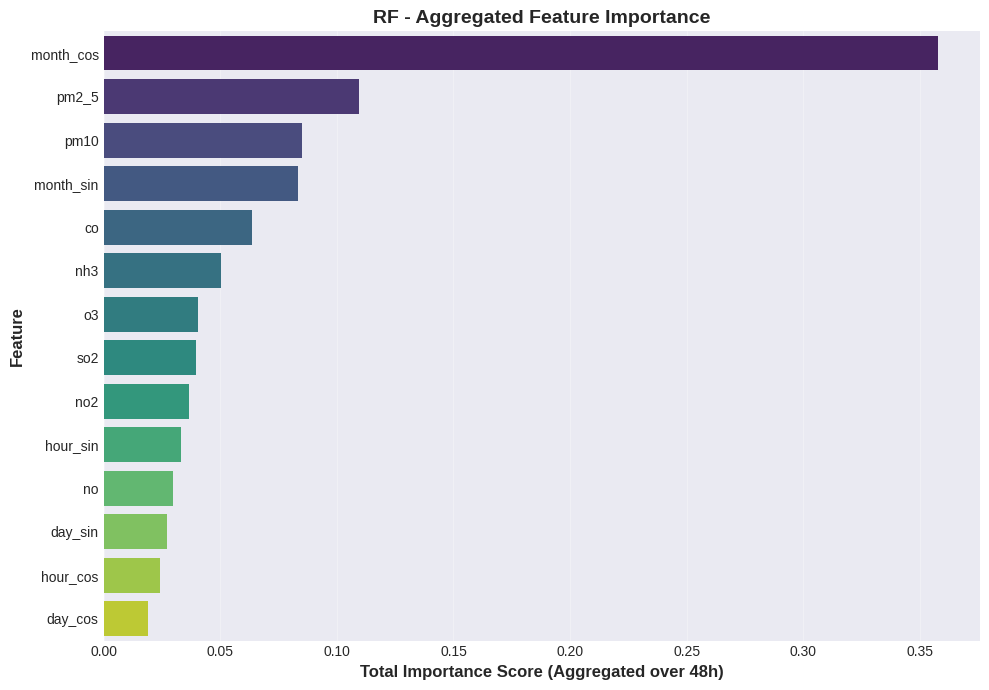

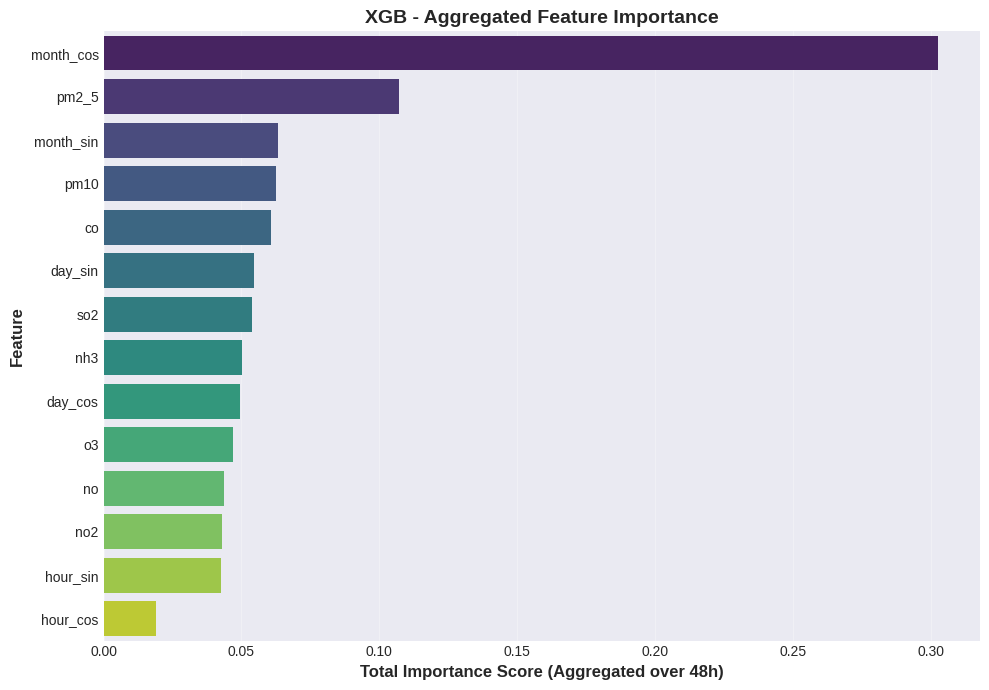

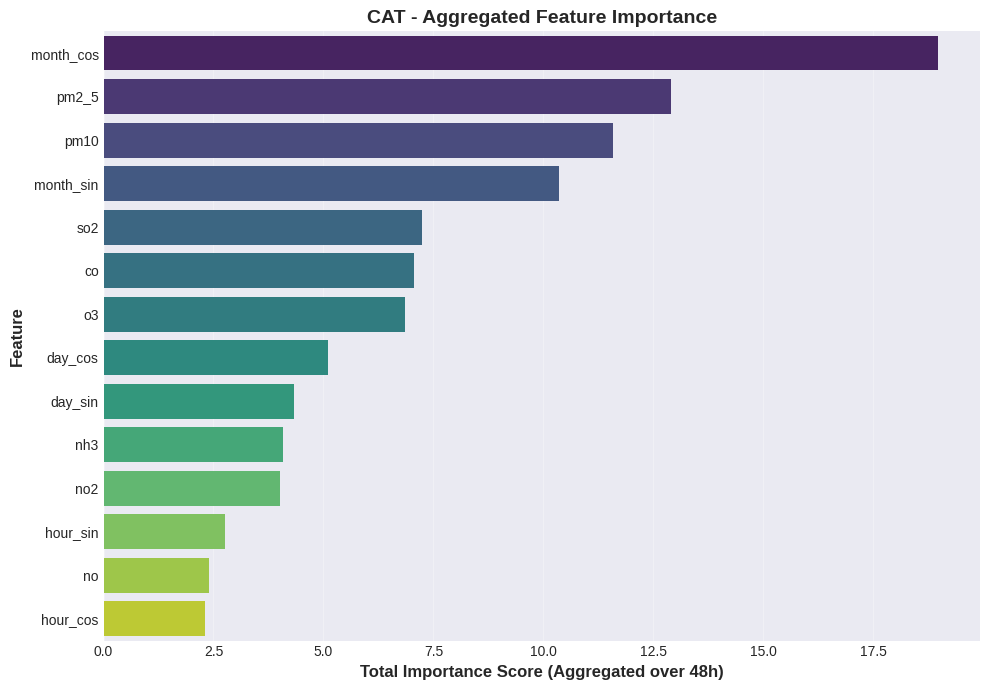

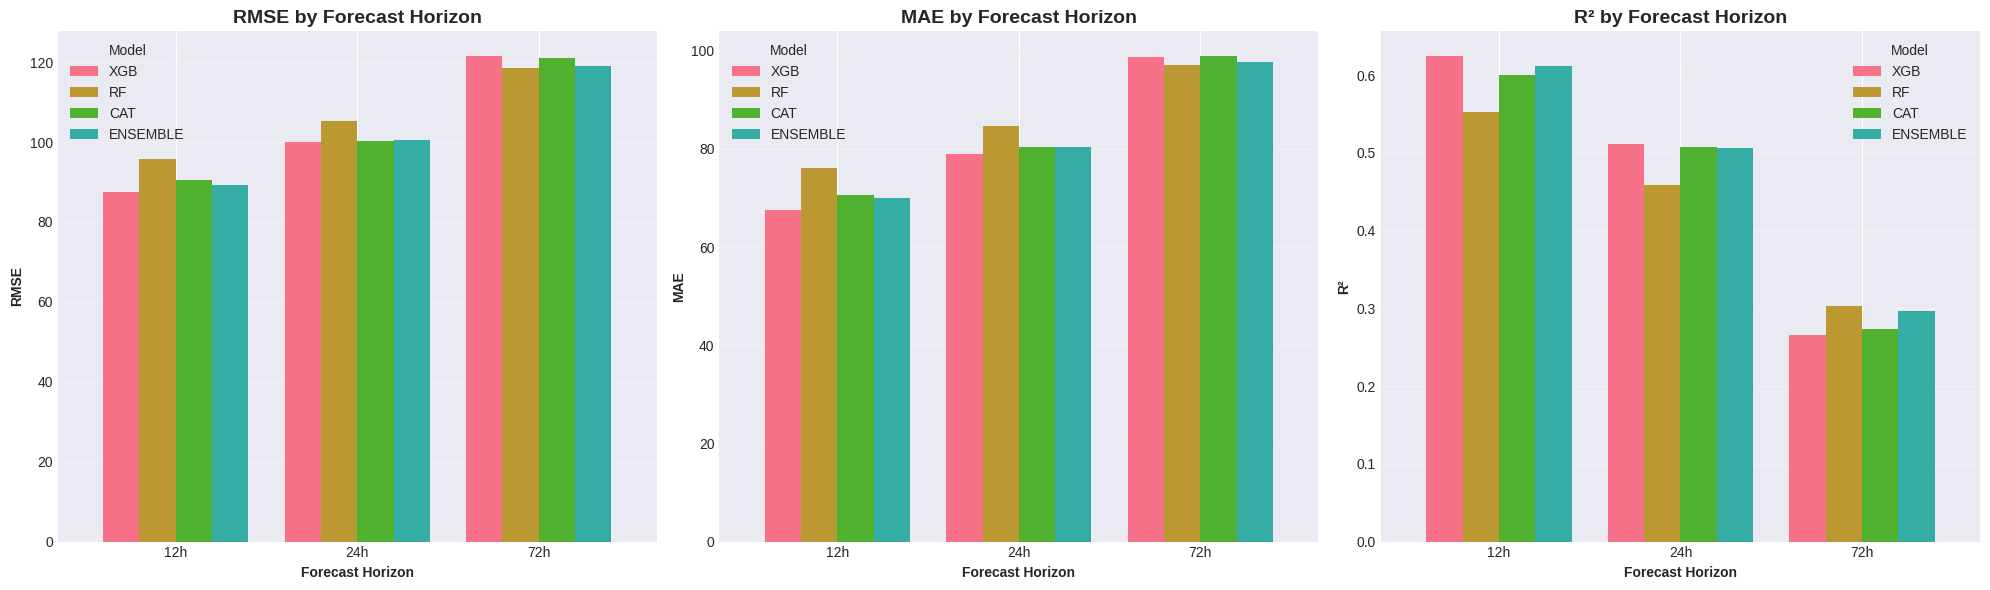

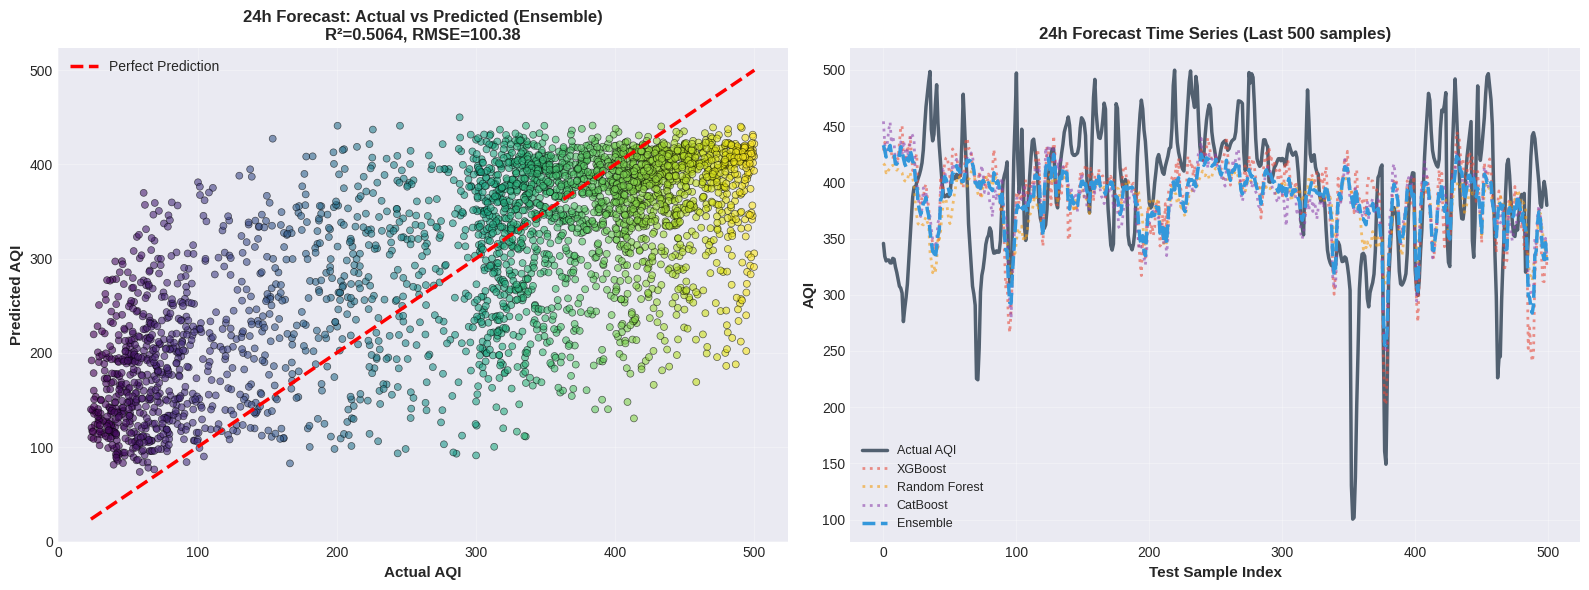

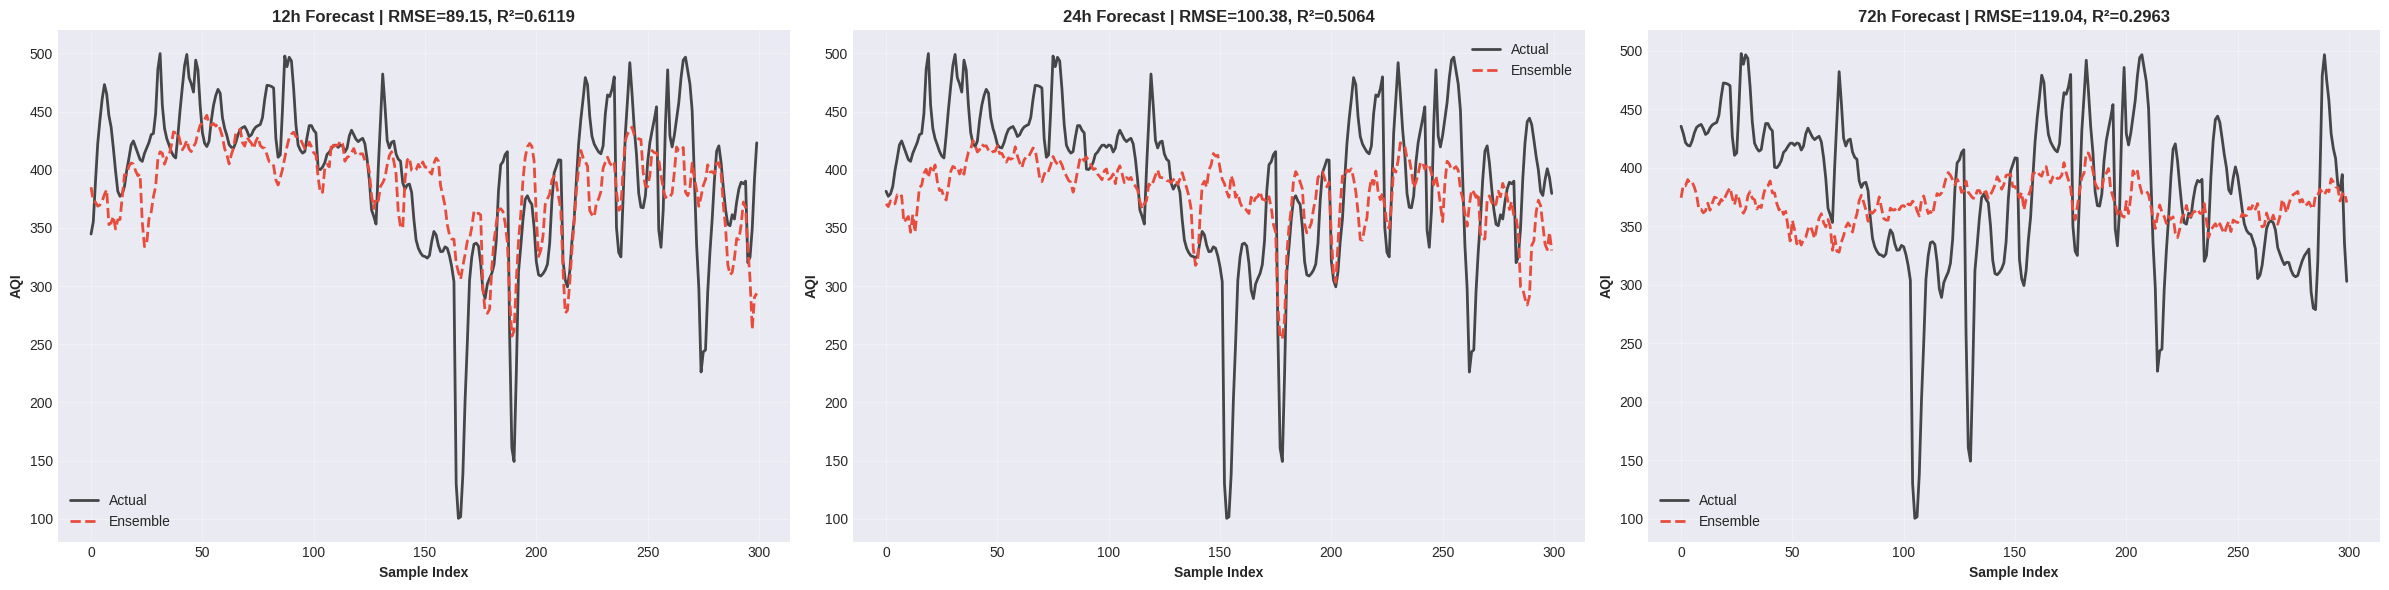

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# --- Configuration ---
N_STEPS_IN = 48
FORECAST_HORIZONS = [12, 24, 72]
ENSEMBLE_WEIGHTS = [0.34, 0.33, 0.33]

# Data sampling for faster training (adjust as needed)
USE_DATA_SAMPLING = True  # Set to False to use all data
SAMPLE_FRACTION = 0.7   # Use 70% of data (randomly sampled)

# --- AQI Calculation Functions ---
def get_sub_index(c, i_high, i_low, c_high, c_low):
    """Interpolates AQI sub-index based on concentration."""
    if c >= c_low and c <= c_high and c_high != c_low:
        return ((i_high - i_low) / (c_high - c_low)) * (c - c_low) + i_low
    return None

def calculate_aqi(row):
    """Calculates AQI using CPCB breakpoints for PM2.5 and PM10."""
    breakpoints_pm25 = [
        (0, 30, 0, 50), (30, 60, 50, 100), (60, 90, 100, 200),
        (90, 120, 200, 300), (120, 250, 300, 400), (250, 500, 400, 500)
    ]
    breakpoints_pm10 = [
        (0, 50, 0, 50), (50, 100, 50, 100), (100, 250, 100, 200),
        (250, 350, 200, 300), (350, 430, 300, 400), (430, 600, 400, 500)
    ]

    sub_indices = []

    pm25_c = row['pm2_5']
    for cl, ch, il, ih in breakpoints_pm25:
        idx = get_sub_index(pm25_c, ih, il, ch, cl)
        if idx is not None:
            sub_indices.append(idx)
            break

    pm10_c = row['pm10']
    for cl, ch, il, ih in breakpoints_pm10:
        idx = get_sub_index(pm10_c, ih, il, ch, cl)
        if idx is not None:
            sub_indices.append(idx)
            break

    if not sub_indices:
        return np.nan
    return max(sub_indices)

# --- Time Series Preparation ---
def create_multi_output_sequences(data, target_data, n_steps_in, target_horizons):
    """Creates time series sequences for multi-output forecasting."""
    X, y = [], []
    max_horizon = max(target_horizons)

    for i in range(len(data) - n_steps_in - max_horizon + 1):
        end_ix = i + n_steps_in
        X.append(data[i:end_ix, :].flatten())

        y_targets = []
        for h in target_horizons:
            target_ix = end_ix + h - 1
            y_targets.append(target_data[target_ix])
        y.append(y_targets)

    return np.array(X), np.array(y)

# --- Data Loading & Preprocessing ---
print("Starting data loading and preprocessing...")
try:
    try:
        df = pd.read_csv('/content/delhi_aqi.csv')
    except FileNotFoundError:
        df = pd.read_csv('delhi_aqi.csv')

    print(f"Loaded {len(df)} records.")

    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)

    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7.0)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7.0)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12.0)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12.0)

    pollutants = ['pm2_5', 'pm10', 'no2', 'so2', 'co', 'o3', 'no', 'nh3']
    temporal = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
    model_features = pollutants + temporal

    for col in pollutants:
        df.loc[df[col] < 0, col] = np.nan

    df[model_features] = df[model_features].fillna(method='ffill').fillna(method='bfill')

    print(f"Created {len(model_features)} features.")

    print("Calculating AQI...")
    df['Net_AQI'] = df.apply(calculate_aqi, axis=1)
    df = df.dropna(subset=['Net_AQI'])

    print(f"AQI Range: {df['Net_AQI'].min():.1f} to {df['Net_AQI'].max():.1f}")

except FileNotFoundError:
    print("\nError: Dataset not found. Please upload 'delhi_aqi.csv'")
    exit()

# --- Feature Scaling ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[model_features].values)
target_data = df['Net_AQI'].values

print(f"Scaled {data_scaled.shape[1]} features.")
print(f"Lookback window: {N_STEPS_IN} hours.")

# --- Create Time Series Sequences ---
print("\nCreating time series sequences...")
X, y = create_multi_output_sequences(data_scaled, target_data, N_STEPS_IN, FORECAST_HORIZONS)

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

if USE_DATA_SAMPLING and SAMPLE_FRACTION < 1.0:
    sample_size = int(len(X_train) * SAMPLE_FRACTION)
    sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
    sample_indices = np.sort(sample_indices)
    X_train = X_train[sample_indices]
    y_train = y_train[sample_indices]
    print(f"Using {len(X_train)} training samples ({SAMPLE_FRACTION*100:.0f}% of total).")

print("Created time series sequences.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape} (Targets: {FORECAST_HORIZONS}h)")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# --- Model Training ---
predictions = {}

print("[1/3] Training XGBoost...")
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    verbosity=0,
    tree_method='hist'
)
xgb_model = MultiOutputRegressor(xgb_base, n_jobs=-1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("[2/3] Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=15,
    min_samples_leaf=5,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("[3/3] Training CatBoost...")
cat_model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.08,
    depth=6,
    loss_function='MultiRMSE',
    random_seed=42,
    verbose=False,
    allow_writing_files=False,
    task_type='CPU',
    thread_count=-1
)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)

w_xgb, w_rf, w_cat = ENSEMBLE_WEIGHTS
y_pred_ensemble = (w_xgb * y_pred_xgb) + (w_rf * y_pred_rf) + (w_cat * y_pred_cat)

predictions = {
    'y_test': y_test,
    'xgb': y_pred_xgb,
    'rf': y_pred_rf,
    'cat': y_pred_cat,
    'ensemble': y_pred_ensemble
}

# --- Model Evaluation ---
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

results = []
y_test_all = predictions['y_test']

for model_name in ['xgb', 'rf', 'cat', 'ensemble']:
    y_pred_all = predictions[model_name]

    for i, horizon in enumerate(FORECAST_HORIZONS):
        y_true_h = y_test_all[:, i]
        y_pred_h = y_pred_all[:, i]

        rmse, mae, r2 = evaluate_model(y_true_h, y_pred_h)

        results.append({
            'Horizon': f'{horizon}h',
            'Model': model_name.upper(),
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        })

results_df = pd.DataFrame(results)
base_model_results = results_df[results_df['Model'] != 'ENSEMBLE']

for horizon in FORECAST_HORIZONS:
    horizon_results = base_model_results[base_model_results['Horizon'] == f'{horizon}h']
    print(f"{horizon}h Ahead Forecast (Base Models):")
    print(horizon_results.sort_values('R²', ascending=False).to_string(index=False))

print(" Overfitting Check (Train vs. Test R²)")
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_rf_train = rf_model.predict(X_train)
y_pred_cat_train = cat_model.predict(X_train)

overfitting_results = []
train_preds_map = {
    'XGB': y_pred_xgb_train,
    'RF': y_pred_rf_train,
    'CAT': y_pred_cat_train
}

for model_name, train_preds in train_preds_map.items():
    for i, horizon in enumerate(FORECAST_HORIZONS):
        test_r2 = results_df[
            (results_df['Model'] == model_name) &
            (results_df['Horizon'] == f'{horizon}h')
        ]['R²'].values[0]

        train_r2 = r2_score(y_train[:, i], train_preds[:, i])

        overfitting_results.append({
            'Horizon': f'{horizon}h',
            'Model': model_name,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Gap': train_r2 - test_r2
        })

overfitting_df = pd.DataFrame(overfitting_results)
pd.set_option('display.float_format', '{:.4f}'.format)
for horizon in FORECAST_HORIZONS:
    print(f"\n{horizon}h Overfitting Check:")
    print(overfitting_df[overfitting_df['Horizon'] == f'{horizon}h'].sort_values('Gap', ascending=False).to_string(index=False))
pd.reset_option('display.float_format')

# Use 24h for best model comparison, as it's common to both
# Filter for 24h results FIRST
results_24h = results_df[results_df['Horizon'] == '24h']
# Now, find the best row *within that subset*
best_row = results_24h.loc[results_24h['R²'].idxmax()]
print(f"Best Model (at 24h): {best_row['Model']}")
print(f"RMSE: {best_row['RMSE']:.2f}")
print(f"MAE: {best_row['MAE']:.2f}")
print(f"R²: {best_row['R²']:.4f}")

# --- Visualizations ---
print(" Generating Visualizations")

def plot_feature_importance(model, model_name, base_feature_names, n_steps_in):
    """
    Calculates and plots aggregated feature importance for flattened time series.
    """
    if model_name == 'XGB':
        try:
            # Average importance across all horizons (estimators)
            importance_flat = np.mean([
                est.feature_importances_ for est in model.estimators_
            ], axis=0)
        except AttributeError:
            print(f"Could not get feature importance for {model_name}. Skipping plot.")
            return
    elif hasattr(model, 'feature_importances_'):
        importance_flat = model.feature_importances_
    elif hasattr(model, 'get_feature_importance'):
        importance_flat = model.get_feature_importance()
    else:
        print(f"Could not get feature importance for {model_name}. Skipping plot.")
        return

    n_base_features = len(base_feature_names)

    if len(importance_flat) != n_steps_in * n_base_features:
        print(f"Importance length mismatch for {model_name}. Skipping plot.")
        print(f"Expected {n_steps_in * n_base_features}, got {len(importance_flat)}")
        return

    try:
        # Reshape to (n_steps, n_features) and sum across time steps
        importance_matrix = importance_flat.reshape((n_steps_in, n_base_features))
        aggregated_importance = importance_matrix.sum(axis=0)
    except Exception as e:
        print(f"Error reshaping importance for {model_name}: {e}. Skipping plot.")
        return

    importance_df = pd.DataFrame({
        'Feature': base_feature_names,
        'Importance': aggregated_importance
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 7))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.xlabel('Total Importance Score (Aggregated over 48h)', fontsize=12, fontweight='bold')
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.title(f'{model_name} - Aggregated Feature Importance', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()

    save_name = f'feature_importance_aggregated_{model_name.lower()}.png'
    plt.savefig(save_name, dpi=200, bbox_inches='tight')
    print(f"Saved: {save_name}")

print("Generating feature importance plots")
plot_feature_importance(rf_model, 'RF', model_features, N_STEPS_IN)
plot_feature_importance(xgb_model, 'XGB', model_features, N_STEPS_IN)
plot_feature_importance(cat_model, 'CAT', model_features, N_STEPS_IN)

print("Generating performance comparison plot")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, metric in enumerate(['RMSE', 'MAE', 'R²']):
    ax = axes[i]
    pivot_data = results_df.pivot(index='Horizon', columns='Model', values=metric)
    pivot_data = pivot_data.reindex(columns=['XGB', 'RF', 'CAT', 'ENSEMBLE'])
    pivot_data.plot(kind='bar', ax=ax, width=0.8)
    ax.set_title(f'{metric} by Forecast Horizon', fontsize=14, fontweight='bold')
    ax.set_xlabel('Forecast Horizon', fontweight='bold')
    ax.set_ylabel(metric, fontweight='bold')
    ax.legend(title='Model', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=200, bbox_inches='tight')
print("Saved: performance_comparison.png")

print("\nGenerating 24h forecast analysis plot")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

horizon_to_plot = 24
h_index = FORECAST_HORIZONS.index(horizon_to_plot)

y_test_h = predictions['y_test'][:, h_index]
y_pred_ensemble_h = predictions['ensemble'][:, h_index]
y_pred_xgb_h = predictions['xgb'][:, h_index]
y_pred_rf_h = predictions['rf'][:, h_index]  # FIXED: was y_pred_route_h
y_pred_cat_h = predictions['cat'][:, h_index]

ax = axes[0]
ax.scatter(y_test_h, y_pred_ensemble_h, alpha=0.6, s=25,
           c=y_test_h, cmap='viridis', edgecolor='black', linewidth=0.5)
min_val, max_val = y_test_h.min(), y_test_h.max()
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2.5, label='Perfect Prediction')
ax.set_xlabel('Actual AQI', fontsize=11, fontweight='bold')
ax.set_ylabel('Predicted AQI', fontsize=11, fontweight='bold')
r2_h = r2_score(y_test_h, y_pred_ensemble_h)
rmse_h = np.sqrt(mean_squared_error(y_test_h, y_pred_ensemble_h))
ax.set_title(f'{horizon_to_plot}h Forecast: Actual vs Predicted (Ensemble)\nR²={r2_h:.4f}, RMSE={rmse_h:.2f}',
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
plot_points = min(500, len(y_test_h))
indices = np.arange(plot_points)

ax.plot(indices, y_test_h[-plot_points:],
        label='Actual AQI', color='#2c3e50', linewidth=2.5, alpha=0.8)
ax.plot(indices, y_pred_xgb_h[-plot_points:],
        label='XGBoost', color='#e74c3c', linestyle=':', alpha=0.6, linewidth=2)
ax.plot(indices, y_pred_rf_h[-plot_points:],
        label='Random Forest', color='#f39c12', linestyle=':', alpha=0.6, linewidth=2)
ax.plot(indices, y_pred_cat_h[-plot_points:],
        label='CatBoost', color='#8e44ad', linestyle=':', alpha=0.6, linewidth=2)
ax.plot(indices, y_pred_ensemble_h[-plot_points:],
        label='Ensemble', color='#3498db', linestyle='--', linewidth=2.5)

ax.set_xlabel('Test Sample Index', fontsize=11, fontweight='bold')
ax.set_ylabel('AQI', fontsize=11, fontweight='bold')
ax.set_title(f'{horizon_to_plot}h Forecast Time Series (Last {plot_points} samples)', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
save_name = f'forecast_{horizon_to_plot}h_analysis.png'
plt.savefig(save_name, dpi=200, bbox_inches='tight')
print(f"Saved: {save_name}")

print("\nGenerating all-horizon comparison plot...")
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for idx, horizon in enumerate(FORECAST_HORIZONS):
    ax = axes[idx]
    h_index = idx
    y_test_h = predictions['y_test'][:, h_index]
    y_pred_ensemble_h = predictions['ensemble'][:, h_index]

    plot_points = min(300, len(y_test_h))
    indices = np.arange(plot_points)

    ax.plot(indices, y_test_h[-plot_points:],
            label='Actual', color='black', linewidth=2, alpha=0.7)
    ax.plot(indices, y_pred_ensemble_h[-plot_points:],
            label='Ensemble', color='#e74c3c', linestyle='--', linewidth=2)

    rmse_h = np.sqrt(mean_squared_error(y_test_h, y_pred_ensemble_h))
    r2_h = r2_score(y_test_h, y_pred_ensemble_h)

    ax.set_title(f'{horizon}h Forecast | RMSE={rmse_h:.2f}, R²={r2_h:.4f}',
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Sample Index', fontweight='bold')
    ax.set_ylabel('AQI', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('all_horizons_comparison.png', dpi=200, bbox_inches='tight')
print("Saved: all_horizons_comparison.png")

# --- Final Summary ---
print("Summary")
print(f"Strategy: Multi-Output (Optimized for Speed)")
print(f"Total records processed: {len(df)}")
print(f"Lookback window: {N_STEPS_IN} hours")
print(f"Features per timestep: {len(model_features)}")
print(f"Total input features: {N_STEPS_IN * len(model_features)}")
print(f"Forecast horizons: {FORECAST_HORIZONS}")

print("\nEnsemble Model Statistics:")
for horizon in FORECAST_HORIZONS:
    ensemble_results = results_df[(results_df['Horizon'] == f'{horizon}h') &
                                  (results_df['Model'] == 'ENSEMBLE')]
    print(f"{horizon}h: RMSE={ensemble_results['RMSE'].values[0]:.2f}, "
          f"R²={ensemble_results['R²'].values[0]:.4f}")

print("\nScript finished.")